In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time

from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

# our modules
from plotSeries import *
from checkStationarity import *
from GoogleTrendsData import *
from makeSeriesStationary import *
from predictorsSelection import *
from dataPreProcessing import *
from tsModels import *
from rollingPredictionfuns import *
from fittedAndPredictedValuefuns import *
from bootstrapfuns import *

# 1. Read data (StatCan)

In [2]:
# Reading file
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')

# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})
retailEcommercesales_ts = retailEcommercesales.copy()

#Changing data type of date
retailEcommercesales=retailEcommercesales.set_index(['Date'])
retailEcommercesales.index = pd.to_datetime(retailEcommercesales.index)
retailEcommercesales_ts = retailEcommercesales_ts.set_index('Date')
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts.index)

# calculate and add growth rate to the dataframe
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA

# check sttaionarity of time series
#check_stationarity(retailEcommercesales_ts[['Growth_rate']])

# 2. Get Google Trends data

In [3]:
# Reading keywords
keywords_csv = pd.read_csv('../../data/keywords_data/EECOMMERCE.csv')

# extracting timeseries dataframe
for index, row in keywords_csv.iterrows():
    #calling Pytrends
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

KeyboardInterrupt: 

In [4]:
# write data to csv
FinalData.to_csv('../../data/storeddata/EcommerceKeywordTimeSeries.csv')

In [4]:
#pre-processing time series
ecommerce_keyword_ts = pd.read_csv('../../data/storeddata/EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

# 3. Make data stationary

In [5]:
#extracting and removing trend
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = (detrend(normalized_ecommerce_keyword))
check_stationarity(detrend_ecommerce_keyword)

Series DoorDash is trend stationary, trend needs to be removed
Series Walmart is trend stationary, trend needs to be removed
Series Canadian Tire is not stationary, differencing can be used to make it stationary
Series Old Navy is not stationary, differencing can be used to make it stationary
Series square online is not stationary, differencing can be used to make it stationary
All other series are stationary


In [6]:
# response and predictors structing
predictor = make_predictors_df(detrend_ecommerce_keyword)
response = make_predictors_df(retailEcommercesales_ts[['Growth_rate']])

# 4. Model fit

In [7]:
# Random Forest

rf_predictors, rf_response = get_lag1_data_ecommerce(retailEcommercesales_ts, detrend_ecommerce_keyword, response_var='Growth_rate')

#Splitting data in training and testing
train_rf, test_rf, extra_rf = ts_train_test_split(rf_response, rf_predictors, test_size=0.2)

#Fitting RF model
rfmodel = randomForest_modelfit(train_rf, response_var='Growth_rate', n_trees=600)
x_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['Growth_rate'])], train_rf[['Growth_rate']]

# fitted growth rate
fitted_growthRate_rf = rfmodel.predict(x_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

#Random Forest Predictions
rf_pred_ecommercegrowth = rolling_prediction_randomForest(train_rf, test_rf, extra_rf,dependent_var='Growth_rate',
                                              n_trees=600)

#rf_pred_retailgrowth

# Fitted and predicted retail sales value
pred_error, fig, data = fitted_and_predicted_sales_ecommerce(rfmodel, 
                                                    rf_pred_ecommercegrowth, 
                                                    retailEcommercesales, train_rf, test_rf, extra_rf)
pred_error

Prediction error: 346861.2427181831


346861.2427181831

In [8]:
# create bootstrap samples
bs_samples = get_bootstrap_samples(train_rf, n_sample=10,block_size=9, rs=RandomState(1234))

In [9]:
# get predicted growth rate uisng bootstrap samples
predicted_growth_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction_randomForest(df, test_rf, extra_rf, dependent_var='Growth_rate',n_trees=100)
    predicted_growth_df.iloc[:, i] = predicted_growth_temp[0]

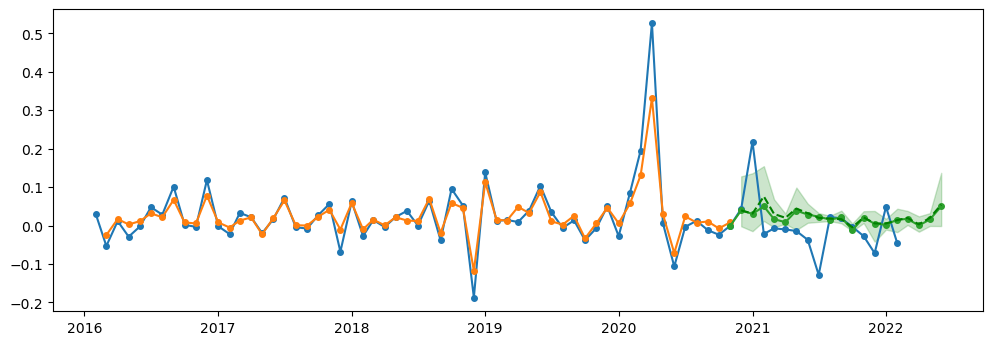

In [10]:
fig, pred_growth_rate_data = growth_rate_plot_and_data_bs_ecommerce(predicted_growth_df=predicted_growth_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= rfmodel, 
                              retailEcommercesales_ts = retailEcommercesales_ts, 
                              train = train_rf,
                              pred_gdpGrowth = rf_pred_ecommercegrowth,fitted_growthrate=fitted_growthRate_rf)

fig

In [11]:
# get predicted gdp value for bootstrap samples

predicted_e_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df[[i]].rename(columns={i: 0})
    _, _, e_data = fitted_and_predicted_sales_ecommerce(rfmodel, predicted_growth_rate_temp, retailEcommercesales, train_rf, test_rf, extra_rf)
    predicted_e_df_bs.iloc[:, i] = e_data['Predicted Retail'].dropna()

Prediction error: 364231.22453458584
Prediction error: 360529.5018780758
Prediction error: 386728.6026858011
Prediction error: 343082.20858561614
Prediction error: 348614.1456190213
Prediction error: 368869.64763644076
Prediction error: 359239.5270627161
Prediction error: 387616.61923039466
Prediction error: 384248.3044844986
Prediction error: 367809.007631903


Prediction error: 346861.2427181831


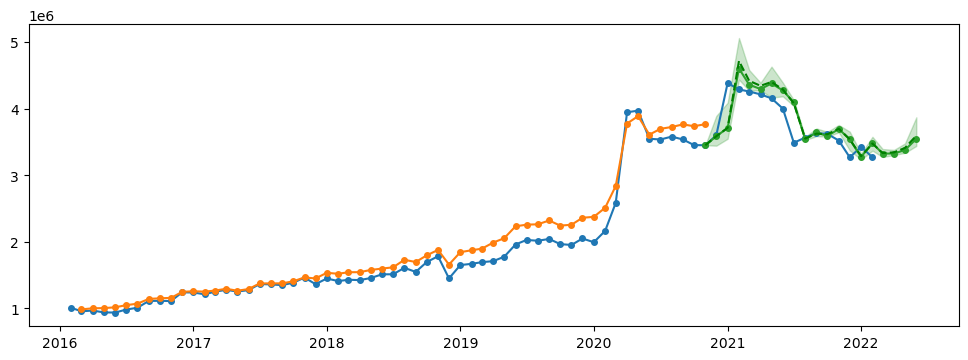

In [12]:
fig, pred_e_data = ecommerce_plot_and_data_bs(rfmodel, rf_pred_ecommercegrowth, retailEcommercesales, train_rf, test_rf, extra_rf, predicted_e_df_bs, 
                                          lower_q = 0.025, upper_q = 0.975)
fig